### Rebuild the good code candidates sent in the Discord chat from these messages

1.) Parse the strings of codes to extract values such as n, k, d etc.

2.) Rebuild the parity check matrices Hx and Hz based on the polynomials

In [1]:
import numpy as np
import re
from bposd.css import css_code
from scipy.sparse import csr_matrix
from bposd.css import css_code
import pickle

In [2]:
with open('/Users/lukasvoss/Documents/Persönliche Unterlagen/Singapur 2023-2024/03_AStar_KishorBharti/02_Research/ldpc_codes/intermediate_results_code_search/slice_code-dim2_l2_m2_weight456/codes_chunk_1.pickle', 'rb') as f:
    codes = pickle.load(f)

In [3]:
codes[126]

{'code_dimension': 'qubit',
 'l': 2,
 'm': 2,
 'num_phys_qubits': 8,
 'num_log_qubits': 4,
 'weight': 6,
 'lx': <4x8 sparse matrix of type '<class 'numpy.int64'>'
 	with 6 stored elements in Compressed Sparse Row format>,
 'lz': <4x8 sparse matrix of type '<class 'numpy.int64'>'
 	with 6 stored elements in Compressed Sparse Row format>,
 'hx': <4x8 sparse matrix of type '<class 'numpy.int64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 'hz': <4x8 sparse matrix of type '<class 'numpy.int64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 'encoding_rate': 0.25,
 'encoding_rate_threshold_exceeded': True,
 'A_poly_sum': 'x1 + y1 + y1 + y1',
 'B_poly_sum': 'x1 + x1'}

In [2]:
def calculate_weight(code):
    """
    Calculate the weight of a quantum error correction code based on its A and B polynomial terms.
    
    Parameters:
    - code (dict): A dictionary representing a quantum error correction code, including 'A_poly_sum' and 'B_poly_sum' keys.

    Returns:
    - int: The weight of the code, calculated as the sum of the number of terms in 'A_poly_sum' and 'B_poly_sum'.
    """
    a_terms = code['A'].count('+') + 1
    b_terms = code['B'].count('+') + 1
    return a_terms + b_terms

In [3]:
def get_stabilizer_checks(config):
    # Extract configuration details
    ell = config['l']
    m = config['m']
    A_poly_sum = config['A']
    B_poly_sum = config['B']

    # Define cyclic shift matrices
    I_ell = np.identity(ell, dtype=int)
    I_m = np.identity(m, dtype=int)
    x, y, z = {}, {}, {}
    
    # Generate base matrices for x and y
    for i in range(ell):
        x[i] = np.kron(np.roll(I_ell, i, axis=1), I_m)
    for j in range(m):
        y[j] = np.kron(I_ell, np.roll(I_m, j, axis=1))
    
    # Generate base matrices for z (assuming z operates similarly)
    for k in range(max(ell, m)):
        z[k] = np.kron(np.roll(I_ell, k, axis=1), np.roll(I_m, k, axis=1))

    # Initialize A and B matrices
    A = np.zeros((ell * m, ell * m), dtype=int)
    B = np.zeros((ell * m, ell * m), dtype=int)

    # Parse A_poly_sum and B_poly_sum to construct A and B
    # This now includes handling for 'z' terms
    # Parse the input string to extract operations and indices
    
    for op, index in re.findall(r'([xyz])(\d+)', A_poly_sum):
        idx = int(index) - 1  # Convert to 0-based index
        if op == 'x' and idx in x:
            A += x[idx]
        elif op == 'y' and idx in y:
            A += y[idx]
        elif op == 'z' and idx in z:
            A += z[idx]
        else:
            print(f"Invalid operation or index: {op}{index}")

    for op, index in re.findall(r'([xyz])(\d+)', B_poly_sum):
        idx = int(index) - 1  # Convert to 0-based index
        if op == 'x' and idx in x:
            B += x[idx]
        elif op == 'y' and idx in y:
            B += y[idx]
        elif op == 'z' and idx in z:
            B += z[idx]
        else:
            print(f"Invalid operation or index: {op}{index}")

    # Ensure matrices are binary
    A %= 2
    B %= 2

    # Transpose matrices A and B to construct hx and hz correctly
    AT = np.transpose(A)
    BT = np.transpose(B)

    # Construct matrices hx and hz
    hx = np.hstack((A, B))
    hz = np.hstack((BT, AT))

    # Assuming css_code is a function that constructs the CSS code given hx and hz
    qcode = css_code(hx, hz)  # Replace css_code with the actual function to create the code object

    # Construct and return the CSS code using hx and hz
    return {
        'hx': csr_matrix(hx),
        'hz': csr_matrix(hz),
    }

In [4]:
def extract_values(input_str: str) -> dict:
    # Define a dictionary to hold the extracted values
    extracted_values = {
        'l': None,
        'm': None,
        'n': None,
        'k': None,        
        'd': None,
        'r': None,
        'w': None,
        'A': None,
        'B': None,
        'lx': None,
    }
    
    # Compile regular expression patterns for matching integers and strings
    int_pattern = r'(?<=\b{}\=)\d+'
    # Adjusted pattern for A and B to stop at a comma or the end of the string
    str_pattern = r'(?<=\b{}\=)[a-z0-9\+\s]+(?=,|\]|\sleads\s)'
    
    # Extract integer values for l, m, n, k, and d
    for key in ['l', 'm', 'n', 'k', 'd']:
        match = re.search(int_pattern.format(key), input_str)
        if match:
            extracted_values[key] = int(match.group(0))

    extracted_values['r'] = extracted_values['k'] / (2*extracted_values['n'])
    
    # Extract string values for A and B with adjustments to stop at specified points
    for key in ['A', 'B']:
        match = re.search(str_pattern.format(key), input_str, re.IGNORECASE)
        if match:
            # Trim any leading or trailing whitespaces
            extracted_values[key] = match.group(0).strip()

    extracted_values['w'] = calculate_weight(extracted_values)
    extracted_values.update(get_stabilizer_checks(extracted_values))
    extracted_values['lx'] = csr_matrix(css_code(extracted_values['hx'].toarray(), extracted_values['hz'].toarray()).lx)

    return extracted_values, extracted_values['w']

In [5]:
def organize_by_weight(code_strings: list) -> dict:
    weight_dict = {}
    for code_str in code_strings:
        values, weight = extract_values(code_str)  # This function now returns the values dict and weight separately
        
        if weight not in weight_dict:
            weight_dict[weight] = [values]  # Start a new list for this weight
        else:
            weight_dict[weight].append(values)  # Append to the existing list for this weight
    
    return weight_dict

In [6]:
code_strings = [
    'Code with l=3, m=8, A=y3 + z2, B=y2 + x2 leads to [[n=48, k=2, d=6]]',
    'Code with l=8, m=4, A=x2 + x1, B=y2 + z1 leads to [[n=64, k=2, d=8]]',
    'Code with l=3, m=5, A=z3 + x1, B=z1 + y3 leads to [[n=30, k=2, d=5]]',
    'Code with l=5, m=5, A=y2 + x4, B=z1 + z3 leads to [[n=50, k=2, d=5]]',
    'Code with l=2, m=4, A=x1 + z1, B=y2 + z3 leads to [[n=16, k=2, d=4]]',
    'Code with l=4, m=6, A=x2 + x1, B=z1 + y4 leads to [[n=48, k=6, d=4]]',
    'Code with l=8, m=2, A=x4 + x5, B=x3 + z5 leads to [[n=32, k=2, d=6]]',
    'Code with l=5, m=3, A=z4 + x2, B=x3 + z1 leads to [[n=30, k=2, d=5]]',
    'Code with l=4, m=4, A=z1 + z2, B=y2 + z1 leads to [[n=32, k=4, d=4]]',
    'Code with l=3, m=8, A=z1 + y2, B=y2 + z3 leads to [[n=48, k=2, d=6]]',
    'Code with l=2, m=4, A=y2 + y3, B=z1 + y2 leads to [[n=16, k=2, d=4]]',
    'Code with l=4, m=2, A=x2 + z1, B=y1 + z1 leads to [[n=16, k=2, d=4]]',
    'Code with l=2, m=4, A=y1 + y2, B=x1 + y1 + z1 + y3 leads to [[n=16, k=4, d=4]]',
    'Code with l=4, m=2, A=x2 + x3, B=x1 + y1 + z1 + x3 leads to [[n=16, k=4, d=4]]',
]

In [7]:
good_code_candidates = organize_by_weight(code_strings)

In [15]:
good_code_candidates

{4: [{'l': 3,
   'm': 8,
   'n': 48,
   'k': 2,
   'r': 0.020833333333333332,
   'w': 4,
   'A': 'y3 + z2',
   'B': 'y2 + x2',
   'lx': <2x48 sparse matrix of type '<class 'numpy.int64'>'
   	with 26 stored elements in Compressed Sparse Row format>,
   'hx': <24x48 sparse matrix of type '<class 'numpy.int64'>'
   	with 96 stored elements in Compressed Sparse Row format>,
   'hz': <24x48 sparse matrix of type '<class 'numpy.int64'>'
   	with 96 stored elements in Compressed Sparse Row format>},
  {'l': 8,
   'm': 4,
   'n': 64,
   'k': 2,
   'r': 0.015625,
   'w': 4,
   'A': 'x2 + x1',
   'B': 'y2 + z1',
   'lx': <2x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 12 stored elements in Compressed Sparse Row format>,
   'hx': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>,
   'hz': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>},
  {'l': 3,
   '

In [20]:
# flat_codes = []
# for weight, codes in good_code_candidates.items():
#     flat_codes.extend(codes)

In [16]:
with open('test_codes.pickle', 'wb') as f:
    pickle.dump(good_code_candidates, f)

In [51]:
with open('/Users/lukasvoss/Documents/Persönliche Unterlagen/Singapur 2023-2024/03_AStar_KishorBharti/02_Research/ldpc_codes/intermediate_results_code_distance_during_ongoing_code_search/good_code_candidates/codes_with_highest_properties_to_be_decoded/good_code_candidates_to_be_decoded.pickle', 'rb') as f:
    codes_dict = pickle.load(f)

In [52]:
codes_dict

{4: [{'l': 8,
   'm': 4,
   'n': 64,
   'k': 2,
   'r': 0.015625,
   'w': 4,
   'A': 'x2 + x1',
   'B': 'y2 + z1',
   'lx': <2x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 12 stored elements in Compressed Sparse Row format>,
   'hx': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>,
   'hz': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>,
   'distance_summary': {'distance': 4, 'distance_list': [8, 4]}},
  {'l': 5,
   'm': 5,
   'n': 50,
   'k': 2,
   'r': 0.02,
   'w': 4,
   'A': 'y2 + x4',
   'B': 'z1 + z3',
   'lx': <2x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 15 stored elements in Compressed Sparse Row format>,
   'hx': <25x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 100 stored elements in Compressed Sparse Row format>,
   'hz': <25x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 100 stored elements

In [46]:
# for weight, codes in codes_dict.items():
#     codes_dict[weight] = [code for code in codes if isinstance(code['distance_summary'], dict) and code['distance_summary']['distance'] >= 3]
#     for code in codes:
#         del code['d']

In [50]:
codes_dict

{4: [{'l': 8,
   'm': 4,
   'n': 64,
   'k': 2,
   'r': 0.015625,
   'w': 4,
   'A': 'x2 + x1',
   'B': 'y2 + z1',
   'lx': <2x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 12 stored elements in Compressed Sparse Row format>,
   'hx': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>,
   'hz': <32x64 sparse matrix of type '<class 'numpy.int64'>'
   	with 128 stored elements in Compressed Sparse Row format>,
   'distance_summary': {'distance': 4, 'distance_list': [8, 4]}},
  {'l': 5,
   'm': 5,
   'n': 50,
   'k': 2,
   'r': 0.02,
   'w': 4,
   'A': 'y2 + x4',
   'B': 'z1 + z3',
   'lx': <2x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 15 stored elements in Compressed Sparse Row format>,
   'hx': <25x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 100 stored elements in Compressed Sparse Row format>,
   'hz': <25x50 sparse matrix of type '<class 'numpy.int64'>'
   	with 100 stored elements

In [ ]:
import matplotlib.pyplot as plt

def plot_results(effective_error, error_rate):
    effective_error_all = np.any(        
        effective_error[:, :, :], axis=2
    )  ##check if any logical error has occurred
    avg_effective_error_all = np.mean(
        effective_error_all, axis=1
    )  ##error occuring for any logical observable

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(error_rate, avg_effective_error_all)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("physical error rate")
    ax.set_ylabel("logical error rate")
    # plt.show()

In [ ]:
# with open('/Users/lukasvoss/Documents/Persönliche Unterlagen/Singapur 2023-2024/03_AStar_KishorBharti/02_Research/ldpc_codes/good_code_candidates_to_be_decoded.pickle', 'rb') as f:
#     test = pickle.load(f)

In [30]:
import pickle
with open('/Users/lukasvoss/Documents/Persönliche Unterlagen/Singapur 2023-2024/03_AStar_KishorBharti/02_Research/ldpc_codes/intermediate_results_decoding/good_code_candidates/codes_decoded.pickle', 'rb') as f:
    decoded_codes = pickle.load(f)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import defaultdict

def plot_decoder_results_by_d_with_labels(data):
    def plot_results(k_grouped_data):
        for k_value, details in k_grouped_data.items():
            plt.figure(figsize=(10, 6))
            for (weight, n, d_value), (effective_errors, error_rates) in details.items():
                # Compute average effective error across all instances for this d value
                avg_effective_errors = np.array([np.mean(np.any(eff_err, axis=2), axis=1) for eff_err in effective_errors])
                avg_error = np.mean(avg_effective_errors, axis=0)

                indices_below = np.where(avg_error < error_rates[0])[0]

                # Check if there are any indices satisfying the condition and find the largest one
                if indices_below.size > 0:
                    pseudo_threshold = avg_error[indices_below.max()]
                    label_str = f'thresh: {pseudo_threshold}'
                else:
                    label_str = '' # 'Pseudo-threshold not reached'
                
                # Using n, k, and d values in the label
                plt.plot(error_rates[0], avg_error, label=f'[[{n}, {k_value}, {d_value}]], {label_str}')  # Assuming error_rate is the same for all entries
            
            plt.xscale("log")
            plt.yscale("log")
            plt.xlabel("Physical error rate")
            plt.ylabel("Logical error rate")
            plt.title(f'Weight: {weight}, k={k_value}')
            plt.legend()
            plt.show()

    # Organizing data
    k_grouped_data = defaultdict(lambda: defaultdict(lambda: ([], [])))  # k -> (n, d) -> (effective_error_list, error_rate)
    for weight, codes in data.items():
        for code in codes:
            k_value = code['k']
            d_value = code['d']
            n_value = code['n']  # Assuming 'n' is part of your dictionary
            decoding_results = code['decoding_results']
            k_grouped_data[k_value][(weight, n_value, d_value)][0].append(decoding_results['effective_error_list'])
            k_grouped_data[k_value][(weight, n_value, d_value)][1].append(decoding_results['error_rate'])
    
    # Plotting
    plot_results(k_grouped_data)

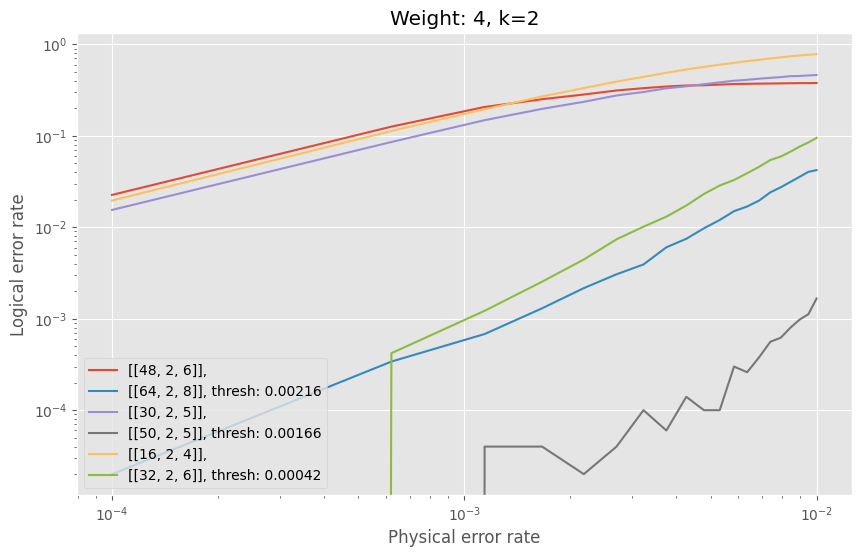

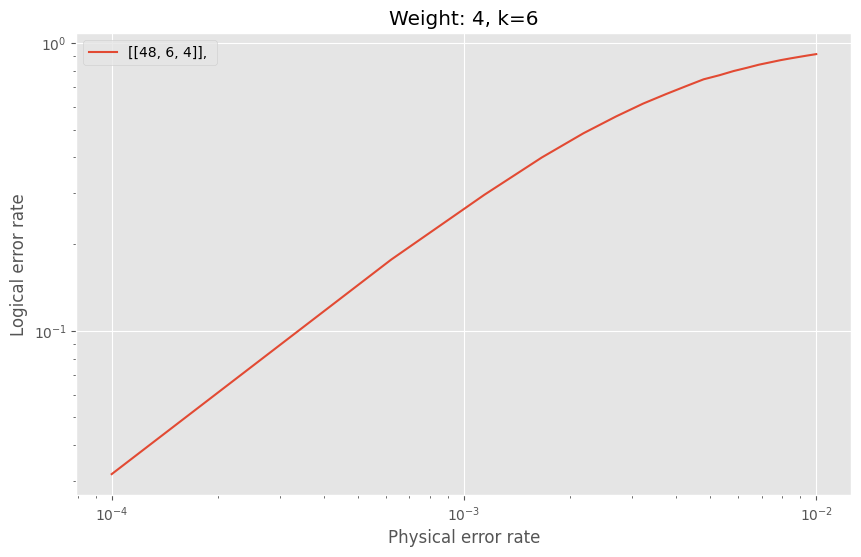

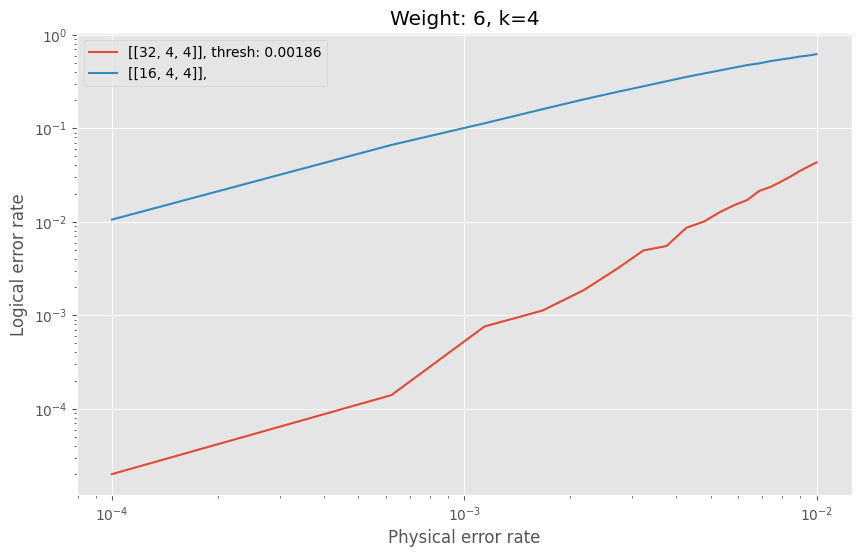

In [32]:
plot_decoder_results_by_d_with_labels(decoded_codes)